# Party Popularity Feature Engineering

## Overview
This notebook implements **Party Popularity** feature engineering for Brazilian legislative voting prediction. Party popularity is calculated as the historical approval rate of propositions by each political party or author type.

## Feature Description
**Party Popularity** represents the success rate of a political party or author type based on their historical voting outcomes:

- **Range**: 0-100% (percentage of previously approved propositions)
- **Calculation**: `approved_sessions / total_sessions * 100`
- **Application**: For each voting session, we calculate the party's popularity based on **previous sessions only** (avoiding data leakage)
- **Scope**: Covers both political parties (PT, PP, PSDB, etc.) and institutional authors (Executive Branch, Legislative Branch, etc.)

## Implementation Approach
1. **Data Enhancement**: Enrich deputy sessions with party information using API data
2. **Temporal Calculation**: Calculate party popularity using only historical data
3. **Window Evaluation**: Test different temporal windows to find optimal predictive performance
4. **Feature Validation**: Evaluate feature quality using imbalanced data metrics

## Methodology for Finding the Optimal Window Size

We implement a **systematic approach** to determine the optimal time window for calculating party popularity. This methodology tests different temporal windows and evaluates their predictive performance on voting outcomes.

### Window Strategies Tested

1. **Full Window**: Use all available historical data
2. **5-Year Window**: Use data from the last 5 years  
3. **1-Year Window**: Use data from the last 1 year
4. **Last 10 Sessions**: Use the last 10 voting sessions by the party
5. **Last 5 Sessions**: Use the last 5 voting sessions by the party
6. **Last 3 Sessions**: Use the last 3 voting sessions by the party  
7. **Last 1 Session**: Use only the immediate previous session by the party

### Evaluation Framework

**Models**: Random Forest and Logistic Regression with `class_weight='balanced'`

**Metrics for Imbalanced Data**:
- **AUROC** (Area Under ROC Curve) - Primary metric
- **AUPRC** (Area Under Precision-Recall Curve)
- **Balanced Accuracy** 
- **Matthews Correlation Coefficient (MCC)**
- **F1-Score for Rejections** (minority class)
- **Recall for Rejections** 
- **Precision for Rejections**

**Data Split**: Chronological split (80% train, 20% test) to simulate real-world prediction

### Expected Party Features
- `party_popularity`: Historical approval rate of the party (0-100%)
- `party_total_sessions`: Total number of previous sessions by the party
- `party_approved_sessions`: Number of previously approved sessions by the party

The optimal window will be selected based on **AUROC performance** for predicting voting outcomes, considering the imbalanced nature of the dataset (≈80% approved, ≈20% rejected).


In [1]:
import pandas as pd

# Carregar o dataset de sessões de votação
df_sessions = pd.read_csv("../data/vote_sessions_full.csv")
df_sessions

,id,uri,data,idOrgao,siglaOrgao,aprovacao,descricao,ultimaAberturaVotacao_descricao,ultimaApresentacaoProposicao_descricao,year,...,União,idProposicao_x,author_type,author,author_type_code,idDeputadoAutor,num_authors,idProposicao_y,theme,legislatura
0,96076-49,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,180,PLEN,1.0,Aprovada a Redação Final oferecida pelo Relato...,Votação da Redação Final.,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",2003,...,0,96076.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,2,96076.0,Esporte e Lazer,52
1,96076-46,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-19,180,PLEN,1.0,Aprovado o Substitutivo oferecido pelo Relator...,Votação em turno único.,"Parecer Proferido em Plenário, Dep. Luiz Eduar...",2003,...,0,96076.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,2,96076.0,Esporte e Lazer,52
2,90170-30,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-26,180,PLEN,1.0,"Aprovado requerimento do Líderes que requer, n...",NaN,Apresentação do Requerimento.,2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52
3,101651-2,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-26,180,PLEN,1.0,Aprovado,NaN,Apresentação do Requerimento.,2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52
4,90170-25,https://dadosabertos.camara.leg.br/api/v2/vota...,2003-02-27,180,PLEN,1.0,Aprovada a Redação Final oferecida pelo Relato...,Votação da Redação Final,"Parecer Proferido em Plenário, Dep. Agnaldo Mu...",2003,...,0,90170.0,Órgão do Poder Executivo,Poder Executivo,30000.0,NaN,4,90170.0,Defesa e Segurança,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41456,2460010-35,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,180,PLEN,0.0,Rejeitado o Requerimento. Sim: 82; Não: 193; T...,NaN,NaN,2024,...,0,2460010.0,Deputado(a),José Guimarães,10000.0,141470.0,6,2460010.0,Finanças Públicas e Orçamento,57
41457,2460010-43,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,180,PLEN,1.0,"Aprovado o Projeto de Lei nº 3.802, de 2024. S...",Votação em turno único.,"Parecer proferido em Plenário pelo Relator, De...",2024,...,0,2460010.0,Deputado(a),José Guimarães,10000.0,141470.0,6,2460010.0,Economia,57
41458,2460010-43,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,180,PLEN,1.0,"Aprovado o Projeto de Lei nº 3.802, de 2024. S...",Votação em turno único.,"Parecer proferido em Plenário pelo Relator, De...",2024,...,0,2460010.0,Deputado(a),José Guimarães,10000.0,141470.0,6,2460010.0,Finanças Públicas e Orçamento,57
41459,2460010-45,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-12-19,180,PLEN,1.0,Aprovada a Redação Final assinada pelo relator...,Votação da Redação Final.,"Parecer proferido em Plenário pelo Relator, De...",2024,...,0,2460010.0,Deputado(a),José Guimarães,10000.0,141470.0,6,2460010.0,Economia,57


In [2]:
author_type_counts = df_sessions['author_type'].value_counts(dropna=False)
print(author_type_counts)

# Contar valores NA/nulos
na_count = df_sessions['author_type'].isna().sum()
print(f"Quantidade de valores NA/nulos: {na_count}")

# Contar valores em branco (string vazia ou só espaços)
blank_count = (df_sessions['author_type'].astype(str).str.strip() == '').sum()
print(f"Quantidade de valores em branco: {blank_count}")


Deputado(a)                          34690
Órgão do Poder Executivo              2869
Órgão do Poder Legislativo            2751
Órgão do Poder Judiciário              607
MPU - Ministério Público da União      127
Sociedade Civil                        105
COMISSÃO PERMANENTE                    100
COMISSÃO ESPECIAL                       47
MISTA CPI                               40
DPU - Defensoria Pública da União       40
COMISSÃO DIRETORA                       28
COMISSÃO PARLAMENTAR DE INQUÉRITO       25
Órgão do Senado Federal                 22
COMISSÃO MEDIDA PROVISÓRIA               6
COMISSÃO MISTA PERMANENTE                3
MISTA ESPECIAL                           1
Name: author_type, dtype: int64
Quantidade de valores NA/nulos: 0
Quantidade de valores em branco: 0


In [3]:
# Import orgaosDeputados-L{legislature}.csv for legislatures 51 to 57, add a column for legislature, and concatenate into one DataFrame
orgaos_deputados_frames = []
for legislature in range(51, 58):  # 51 to 57 inclusive
    file_path = f"../../data/extra/orgaosDeputados-L{legislature}.csv"
    try:
        df = pd.read_csv(file_path, sep=';')
        # Extract deputy id from uriDeputado and save in a new column 'idDeputado'
        if 'uriDeputado' in df.columns:
            df['idDeputado'] = df['uriDeputado'].astype(str).str.extract(r'/(\d+)$')
        df['legislature'] = legislature  # Add a column to identify the legislature
        orgaos_deputados_frames.append(df)
    except FileNotFoundError:
        print(f"File not found for legislature {legislature}: {file_path}")
    except pd.errors.ParserError as e:
        print(f"ParserError for legislature {legislature}: {e}. Skipping this file.")

# Concatenate all DataFrames into a single DataFrame
if orgaos_deputados_frames:
    orgaos_deputados_df = pd.concat(orgaos_deputados_frames, ignore_index=True)
    display(orgaos_deputados_df.head())
else:
    print("No orgaosDeputados data loaded.")

,uriOrgao,siglaOrgao,nomeOrgao,nomePublicacaoOrgao,uriDeputado,nomeDeputado,siglaPartido,siglaUF,cargo,dataInicio,dataFim,idDeputado,legislature
0,https://dadosabertos.camara.leg.br/api/v2/orga...,MESA,Mesa Diretora da Câmara dos Deputados,Mesa Diretora,https://dadosabertos.camara.leg.br/api/v2/depu...,Aécio Neves,PSDB,MG,Presidente,2001-02-14,2002-12-17,74646,51
1,https://dadosabertos.camara.leg.br/api/v2/orga...,MESA,Mesa Diretora da Câmara dos Deputados,Mesa Diretora,https://dadosabertos.camara.leg.br/api/v2/depu...,Barbosa Neto,NaN,NaN,2º Vice-Presidente,2001-02-15,2003-01-31,73663,51
2,https://dadosabertos.camara.leg.br/api/v2/orga...,MESA,Mesa Diretora da Câmara dos Deputados,Mesa Diretora,https://dadosabertos.camara.leg.br/api/v2/depu...,Ciro Nogueira,NaN,NaN,4º Secretário,2001-02-15,2003-01-31,74313,51
3,https://dadosabertos.camara.leg.br/api/v2/orga...,MESA,Mesa Diretora da Câmara dos Deputados,Mesa Diretora,https://dadosabertos.camara.leg.br/api/v2/depu...,Efraim Morais,NaN,NaN,4º Secretário,1999-02-02,2001-02-14,74407,51
4,https://dadosabertos.camara.leg.br/api/v2/orga...,MESA,Mesa Diretora da Câmara dos Deputados,Mesa Diretora,https://dadosabertos.camara.leg.br/api/v2/depu...,Efraim Morais,NaN,NaN,1º Vice-Presidente,2001-02-15,2002-12-17,74407,51


In [4]:
# First, let's remove duplicates and check data shape
print("Original df_sessions shape:", df_sessions.shape)

# Remove duplicates based on 'id' column
print("Removing duplicates based on 'id' column...")
df_sessions_clean = df_sessions.drop_duplicates(subset=['id'], keep='first')
print("After removing duplicates shape:", df_sessions_clean.shape)
print(f"Removed {df_sessions.shape[0] - df_sessions_clean.shape[0]} duplicate rows")

# Use the cleaned dataframe
df_sessions = df_sessions_clean


Original df_sessions shape: (41461, 171)
Removing duplicates based on 'id' column...
After removing duplicates shape: (9260, 171)
Removed 32201 duplicate rows


In [5]:
# Create a new column with party information for deputies and author_type for others (FIXED VERSION)
import time

print("Starting party assignment process...")
start_time = time.time()

# FIXED: Properly convert ID columns to the same format
print("Converting ID columns to string format...")
# For df_sessions: convert float to int first (to remove .0), then to string, handle NaN
df_sessions['idDeputadoAutor_str'] = df_sessions['idDeputadoAutor'].fillna(-1).astype(int).astype(str)
df_sessions.loc[df_sessions['idDeputadoAutor'].isna(), 'idDeputadoAutor_str'] = 'nan'

# For orgaos_deputados_df: already string, just ensure it's string type
orgaos_deputados_df['idDeputado_str'] = orgaos_deputados_df['idDeputado'].astype(str)

# Quick verification of ID matching after fix
print("Verifying ID matching after fix...")
orgaos_ids_fixed = set(orgaos_deputados_df['idDeputado_str'].dropna())
sessions_ids_fixed = set(df_sessions[df_sessions['author_type'] == 'Deputado(a)']['idDeputadoAutor_str'].dropna())
sessions_ids_fixed.discard('nan')  # Remove 'nan' values
sessions_ids_fixed.discard('-1')   # Remove -1 values (converted from NaN)

overlapping_fixed = orgaos_ids_fixed.intersection(sessions_ids_fixed)
print(f"After fix - Overlapping IDs: {len(overlapping_fixed)}")
print(f"Sample overlapping IDs: {list(overlapping_fixed)[:10]}")

print("Creating optimized deputy-party lookup...")
# Create a more efficient lookup dictionary
# For each deputy-legislature combination, store the party
deputy_party_lookup = {}
for _, row in orgaos_deputados_df.iterrows():
    deputy_id = row['idDeputado_str']
    legislature = row['legislature']
    party = row['siglaPartido']
    
    if pd.notna(party) and deputy_id != 'nan':
        key = f"{deputy_id}_{legislature}"
        deputy_party_lookup[key] = party

print(f"Created lookup with {len(deputy_party_lookup)} deputy-legislature-party combinations")

# Create fallback lookup (closest legislature for each deputy)
print("Creating fallback lookup for missing legislature matches...")
deputy_fallback_lookup = {}
for deputy_id in orgaos_deputados_df['idDeputado_str'].unique():
    if deputy_id != 'nan':
        deputy_records = orgaos_deputados_df[orgaos_deputados_df['idDeputado_str'] == deputy_id]
        # Get the most recent legislature with party info
        recent_with_party = deputy_records.dropna(subset=['siglaPartido']).sort_values('legislature', ascending=False)
        if not recent_with_party.empty:
            deputy_fallback_lookup[deputy_id] = recent_with_party.iloc[0]['siglaPartido']

print(f"Created fallback lookup with {len(deputy_fallback_lookup)} deputies")

# Optimized function to get party (now receives pre-processed string IDs)
def get_deputy_party_fast(deputy_id_str, legislatura):
    if deputy_id_str == 'nan' or deputy_id_str == '-1':
        return None
    
    # Try exact match first
    key = f"{deputy_id_str}_{legislatura}"
    if key in deputy_party_lookup:
        return deputy_party_lookup[key]
    
    # Try fallback
    if deputy_id_str in deputy_fallback_lookup:
        return deputy_fallback_lookup[deputy_id_str]
    
    return None

# Initialize the new column with author_type for non-deputies
print("Initializing party_or_author_type column...")
df_sessions['party_or_author_type'] = df_sessions['author_type'].copy()

# Process deputies only (much faster than apply on all rows)
deputy_mask = df_sessions['author_type'] == 'Deputado(a)'
deputy_sessions = df_sessions[deputy_mask]
total_deputies = len(deputy_sessions)

print(f"Processing {total_deputies} deputy sessions...")

# Process in chunks for progress tracking
chunk_size = 1000
processed = 0

for i in range(0, total_deputies, chunk_size):
    chunk_end = min(i + chunk_size, total_deputies)
    chunk = deputy_sessions.iloc[i:chunk_end]
    
    # Process the chunk
    for idx, row in chunk.iterrows():
        party = get_deputy_party_fast(row['idDeputadoAutor_str'], row['legislatura'])
        if party is not None:
            df_sessions.loc[idx, 'party_or_author_type'] = party
    
    processed = chunk_end
    elapsed_time = time.time() - start_time
    progress_percent = (processed / total_deputies) * 100
    est_remaining = (elapsed_time / processed) * (total_deputies - processed) if processed > 0 else 0
    
    print(f"Progress: {processed}/{total_deputies} ({progress_percent:.1f}%) - "
          f"Elapsed: {elapsed_time:.1f}s - Estimated remaining: {est_remaining:.1f}s")

print(f"\nCompleted in {time.time() - start_time:.2f} seconds!")

# Check the results
print("\nValue counts for the new party_or_author_type column:")
print(df_sessions['party_or_author_type'].value_counts().head(20))

# Check specifically for deputies
deputy_sessions_final = df_sessions[df_sessions['author_type'] == 'Deputado(a)']
print(f"\nTotal sessions authored by deputies: {len(deputy_sessions_final)}")
print(f"Deputies with party info found: {(deputy_sessions_final['party_or_author_type'] != 'Deputado(a)').sum()}")
print(f"Deputies without party info (still showing as 'Deputado(a)'): {(deputy_sessions_final['party_or_author_type'] == 'Deputado(a)').sum()}")

# Show sample of deputy sessions with party info
print("\nSample of deputy sessions with party information:")
sample_deputy_with_party = deputy_sessions_final[deputy_sessions_final['party_or_author_type'] != 'Deputado(a)'].head()
if not sample_deputy_with_party.empty:
    print(sample_deputy_with_party[['author', 'idDeputadoAutor', 'author_type', 'party_or_author_type', 'legislatura']].to_string())
else:
    print("No deputies with party information found in the sample.")

# Show statistics by legislature
print("\nDeputy sessions by legislature:")
deputy_stats = deputy_sessions_final.groupby('legislatura').agg({
    'party_or_author_type': lambda x: (x != 'Deputado(a)').sum(),
    'idDeputadoAutor': 'count'
}).rename(columns={'party_or_author_type': 'with_party', 'idDeputadoAutor': 'total'})
deputy_stats['percentage_with_party'] = (deputy_stats['with_party'] / deputy_stats['total'] * 100).round(2)
print(deputy_stats)


Starting party assignment process...
Converting ID columns to string format...
Verifying ID matching after fix...
After fix - Overlapping IDs: 644
Sample overlapping IDs: ['141417', '204412', '204383', '160600', '74158', '143084', '77701', '204535', '74324', '156190']
Creating optimized deputy-party lookup...


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_23188\4142749372.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessions['idDeputadoAutor_str'] = df_sessions['idDeputadoAutor'].fillna(-1).astype(int).astype(str)


Created lookup with 1195 deputy-legislature-party combinations
Creating fallback lookup for missing legislature matches...
Created fallback lookup with 514 deputies
Initializing party_or_author_type column...
Processing 5130 deputy sessions...
Progress: 1000/5130 (19.5%) - Elapsed: 26.8s - Estimated remaining: 110.8s


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_23188\4142749372.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessions['party_or_author_type'] = df_sessions['author_type'].copy()


Progress: 2000/5130 (39.0%) - Elapsed: 26.9s - Estimated remaining: 42.2s
Progress: 3000/5130 (58.5%) - Elapsed: 27.0s - Estimated remaining: 19.2s
Progress: 4000/5130 (78.0%) - Elapsed: 27.2s - Estimated remaining: 7.7s
Progress: 5000/5130 (97.5%) - Elapsed: 27.3s - Estimated remaining: 0.7s
Progress: 5130/5130 (100.0%) - Elapsed: 27.4s - Estimated remaining: 0.0s

Completed in 27.36 seconds!

Value counts for the new party_or_author_type column:
Deputado(a)                          3150
Órgão do Poder Executivo             1734
Órgão do Poder Legislativo           1619
Órgão do Poder Judiciário             412
PL                                    265
PT                                    263
PSD                                   238
UNIÃO                                 216
REPUBLIC                              179
MDB                                   138
PP                                    121
PDT                                   115
MPU - Ministério Público da União     108
PO

In [6]:
# Let's debug the ID matching issue
print("=== DEBUGGING ID MATCHING ===")

# Check the deputy ID extraction in orgaos_deputados_df
print("Sample of orgaos_deputados_df uriDeputado and extracted idDeputado:")
sample_orgaos = orgaos_deputados_df[['uriDeputado', 'idDeputado', 'siglaPartido', 'legislature']].head(10)
print(sample_orgaos)

# Check deputy IDs in df_sessions
print("\nSample of df_sessions idDeputadoAutor:")
sample_sessions = df_sessions[df_sessions['author_type'] == 'Deputado(a)'][['author', 'idDeputadoAutor', 'legislatura']].head(10)
print(sample_sessions)

# Check data types
print(f"\norgaos_deputados_df['idDeputado'] dtype: {orgaos_deputados_df['idDeputado'].dtype}")
print(f"df_sessions['idDeputadoAutor'] dtype: {df_sessions['idDeputadoAutor'].dtype}")

# Check for any NaN values in the extraction
print(f"\nNaN values in orgaos_deputados_df['idDeputado']: {orgaos_deputados_df['idDeputado'].isna().sum()}")
print(f"NaN values in df_sessions['idDeputadoAutor']: {df_sessions['idDeputadoAutor'].isna().sum()}")

# Check unique values to see if there's overlap
orgaos_ids = set(orgaos_deputados_df['idDeputado'].dropna().astype(str))
sessions_ids = set(df_sessions[df_sessions['author_type'] == 'Deputado(a)']['idDeputadoAutor'].dropna().astype(str))

print(f"\nUnique deputy IDs in orgaos_deputados_df: {len(orgaos_ids)}")
print(f"Unique deputy IDs in df_sessions (deputies only): {len(sessions_ids)}")
print(f"Overlapping IDs: {len(orgaos_ids.intersection(sessions_ids))}")

print(f"\nSample orgaos IDs: {list(orgaos_ids)[:10]}")
print(f"Sample sessions IDs: {list(sessions_ids)[:10]}")

# Let's also check if the ID extraction is working correctly
print("\n=== Testing ID extraction ===")
sample_uri = "https://dadosabertos.camara.leg.br/api/v2/deputados/220593"
import re
extracted_id = re.findall(r'/(\d+)$', sample_uri)
print(f"Sample URI: {sample_uri}")
print(f"Extracted ID: {extracted_id}")

# Check a few actual URIs from the data
actual_uris = orgaos_deputados_df['uriDeputado'].dropna().head(5)
for uri in actual_uris:
    extracted = re.findall(r'/(\d+)$', str(uri))
    print(f"URI: {uri} -> Extracted: {extracted}")


=== DEBUGGING ID MATCHING ===
Sample of orgaos_deputados_df uriDeputado and extracted idDeputado:
                                         uriDeputado idDeputado siglaPartido  \
0  https://dadosabertos.camara.leg.br/api/v2/depu...      74646         PSDB   
1  https://dadosabertos.camara.leg.br/api/v2/depu...      73663          NaN   
2  https://dadosabertos.camara.leg.br/api/v2/depu...      74313          NaN   
3  https://dadosabertos.camara.leg.br/api/v2/depu...      74407          NaN   
4  https://dadosabertos.camara.leg.br/api/v2/depu...      74407          NaN   
5  https://dadosabertos.camara.leg.br/api/v2/depu...      74407          NaN   
6  https://dadosabertos.camara.leg.br/api/v2/depu...      73893          NaN   
7  https://dadosabertos.camara.leg.br/api/v2/depu...      74077          NaN   
8  https://dadosabertos.camara.leg.br/api/v2/depu...      74419          NaN   
9  https://dadosabertos.camara.leg.br/api/v2/depu...      97707          NaN   

   legislature  
0   

In [7]:
# Fetch missing party information using the Câmara API
import requests
import json
import time
from time import sleep

print("=== FETCHING MISSING PARTY INFO VIA API ===")

# Get unique deputy IDs that still don't have party info
deputies_without_party = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] == 'Deputado(a)')
]

unique_missing_deputies = deputies_without_party['idDeputadoAutor_str'].unique()
# Remove invalid IDs
unique_missing_deputies = [dep_id for dep_id in unique_missing_deputies if dep_id not in ['nan', '-1']]

print(f"Found {len(unique_missing_deputies)} unique deputies without party info")
print(f"Sample IDs to fetch: {unique_missing_deputies[:10]}")

# Function to fetch deputy info from API
def fetch_deputy_party(deputy_id):
    """Fetch party information for a deputy from the Câmara API"""
    url = f"https://dadosabertos.camara.leg.br/api/v2/deputados/{deputy_id}"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        data = response.json()
        
        # Extract party from the response
        if 'dados' in data and 'ultimoStatus' in data['dados']:
            party = data['dados']['ultimoStatus'].get('siglaPartido')
            return party
        else:
            print(f"  Warning: Unexpected API response structure for deputy {deputy_id}")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"  Error fetching deputy {deputy_id}: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"  JSON decode error for deputy {deputy_id}: {e}")
        return None
    except Exception as e:
        print(f"  Unexpected error for deputy {deputy_id}: {e}")
        return None

# Fetch party information with progress tracking and rate limiting
api_party_lookup = {}
total_to_fetch = len(unique_missing_deputies)
fetched_count = 0
success_count = 0

print(f"\nStarting API fetch for {total_to_fetch} deputies...")
start_time_api = time.time()

for i, deputy_id in enumerate(unique_missing_deputies):
    if i % 10 == 0:  # Progress update every 10 requests
        elapsed = time.time() - start_time_api
        progress_pct = (i / total_to_fetch) * 100
        est_remaining = (elapsed / max(i, 1)) * (total_to_fetch - i)
        print(f"Progress: {i}/{total_to_fetch} ({progress_pct:.1f}%) - "
              f"Elapsed: {elapsed:.1f}s - Est. remaining: {est_remaining:.1f}s - "
              f"Success rate: {success_count}/{i} ({(success_count/max(i,1)*100):.1f}%)")
    
    party = fetch_deputy_party(deputy_id)
    if party:
        api_party_lookup[deputy_id] = party
        success_count += 1
    
    fetched_count += 1
    
    # Rate limiting: wait 0.1 seconds between requests to be respectful to the API
    sleep(0.1)

print(f"\nAPI fetch completed!")
print(f"Total requests: {fetched_count}")
print(f"Successful responses: {success_count}")
print(f"Success rate: {(success_count/fetched_count*100):.1f}%")
print(f"Total time: {time.time() - start_time_api:.2f} seconds")

# Show sample of fetched data
print(f"\nSample of fetched party data:")
sample_items = list(api_party_lookup.items())[:10]
for dep_id, party in sample_items:
    print(f"  Deputy {dep_id}: {party}")

# Update the dataframe with the fetched party information
print(f"\nUpdating dataframe with API-fetched party information...")
update_count = 0

for idx, row in df_sessions.iterrows():
    if (row['author_type'] == 'Deputado(a)' and 
        row['party_or_author_type'] == 'Deputado(a)' and
        row['idDeputadoAutor_str'] in api_party_lookup):
        
        df_sessions.loc[idx, 'party_or_author_type'] = api_party_lookup[row['idDeputadoAutor_str']]
        update_count += 1

print(f"Updated {update_count} rows with API-fetched party information")

# Final results
print(f"\n=== FINAL RESULTS ===")
print("Updated value counts for party_or_author_type column:")
print(df_sessions['party_or_author_type'].value_counts().head(25))

# Final statistics for deputies
deputy_sessions_final = df_sessions[df_sessions['author_type'] == 'Deputado(a)']
total_deputies = len(deputy_sessions_final)
with_party = (deputy_sessions_final['party_or_author_type'] != 'Deputado(a)').sum()
without_party = (deputy_sessions_final['party_or_author_type'] == 'Deputado(a)').sum()

print(f"\nFinal deputy statistics:")
print(f"Total deputy sessions: {total_deputies}")
print(f"With party info: {with_party} ({(with_party/total_deputies*100):.1f}%)")
print(f"Still without party info: {without_party} ({(without_party/total_deputies*100):.1f}%)")

# Statistics by legislature
print("\nFinal deputy sessions by legislature:")
deputy_stats_final = deputy_sessions_final.groupby('legislatura').agg({
    'party_or_author_type': lambda x: (x != 'Deputado(a)').sum(),
    'idDeputadoAutor': 'count'
}).rename(columns={'party_or_author_type': 'with_party', 'idDeputadoAutor': 'total'})
deputy_stats_final['percentage_with_party'] = (deputy_stats_final['with_party'] / deputy_stats_final['total'] * 100).round(2)
print(deputy_stats_final)


=== FETCHING MISSING PARTY INFO VIA API ===
Found 400 unique deputies without party info
Sample IDs to fetch: ['73947', '74082', '73558', '73431', '74416', '73584', '74665', '74538', '74209', '74058']

Starting API fetch for 400 deputies...
Progress: 0/400 (0.0%) - Elapsed: 0.0s - Est. remaining: 0.4s - Success rate: 0/0 (0.0%)
Progress: 10/400 (2.5%) - Elapsed: 9.4s - Est. remaining: 366.0s - Success rate: 10/10 (100.0%)
Progress: 20/400 (5.0%) - Elapsed: 18.2s - Est. remaining: 346.5s - Success rate: 20/20 (100.0%)
Progress: 30/400 (7.5%) - Elapsed: 27.2s - Est. remaining: 336.0s - Success rate: 30/30 (100.0%)
Progress: 40/400 (10.0%) - Elapsed: 36.4s - Est. remaining: 327.3s - Success rate: 40/40 (100.0%)
Progress: 50/400 (12.5%) - Elapsed: 45.3s - Est. remaining: 316.9s - Success rate: 50/50 (100.0%)
Progress: 60/400 (15.0%) - Elapsed: 54.5s - Est. remaining: 308.9s - Success rate: 60/60 (100.0%)
Progress: 70/400 (17.5%) - Elapsed: 63.5s - Est. remaining: 299.3s - Success rate: 70/

In [8]:
# Display the updated dataset with deputies' party information
print("=== UPDATED DATASET WITH DEPUTY PARTY INFORMATION ===")

# Show sample of updated deputy sessions with party information
print("Sample of deputy sessions with party information:")
deputy_with_parties = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)')
].head(15)

display(deputy_with_parties[['id', 'data', 'author', 'idDeputadoAutor', 'author_type', 'party_or_author_type', 'legislatura', 'aprovacao']])

# Show complete party distribution
print("\n=== COMPLETE PARTY DISTRIBUTION ===")
party_counts = df_sessions['party_or_author_type'].value_counts()
print("All parties/author types:")
print(party_counts)

# Focus on just the political parties (exclude other author types)
print("\n=== POLITICAL PARTIES ONLY ===")
# Filter out non-party entities
non_party_entities = [
    'Deputado(a)', 'Órgão do Poder Executivo', 'Órgão do Poder Legislativo', 
    'Órgão do Poder Judiciário', 'MPU - Ministério Público da União',
    'COMISSÃO PERMANENTE', 'COMISSÃO ESPECIAL', 'Sociedade Civil',
    'DPU - Defensoria Pública da União', 'COMISSÃO DIRETORA',
    'COMISSÃO PARLAMENTAR DE INQUÉRITO', 'MISTA CPI', 'Órgão do Senado Federal',
    'COMISSÃO MISTA PERMANENTE', 'COMISSÃO MEDIDA PROVISÓRIA', 'MISTA ESPECIAL'
]

political_parties = df_sessions[~df_sessions['party_or_author_type'].isin(non_party_entities)]
party_distribution = political_parties['party_or_author_type'].value_counts()
print("Political parties distribution:")
print(party_distribution)

print(f"\nTotal political party sessions: {len(political_parties)}")
print(f"Number of different parties: {len(party_distribution)}")

# Show party distribution by legislature
print("\n=== PARTY DISTRIBUTION BY LEGISLATURE ===")
party_by_legislature = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)')
].groupby(['legislatura', 'party_or_author_type']).size().unstack(fill_value=0)

print("Deputy sessions by legislature and party:")
print(party_by_legislature)

# Show top parties by number of sessions
print("\n=== TOP 10 PARTIES BY NUMBER OF SESSIONS ===")
top_parties = party_distribution.head(10)
for i, (party, count) in enumerate(top_parties.items(), 1):
    percentage = (count / len(political_parties)) * 100
    print(f"{i:2d}. {party:<12} : {count:4d} sessions ({percentage:5.1f}%)")

# Show party success by approval rate
print("\n=== PARTY SUCCESS RATES (Average Approval) ===")
party_approval = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)') &
    (df_sessions['aprovacao'].notna())
].groupby('party_or_author_type').agg({
    'aprovacao': ['count', 'mean', 'std']
}).round(3)

party_approval.columns = ['Sessions', 'Avg_Approval', 'Std_Approval']
party_approval = party_approval.sort_values('Avg_Approval', ascending=False)
print("Parties ranked by average approval rate:")
print(party_approval)

# Show recent vs older legislatures
print("\n=== RECENT vs OLDER LEGISLATURES COMPARISON ===")
recent_legs = [56, 57]  # More recent legislatures
older_legs = [52, 53, 54, 55]  # Older legislatures

recent_parties = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)') &
    (df_sessions['legislatura'].isin(recent_legs))
]['party_or_author_type'].value_counts().head(10)

older_parties = df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)') &
    (df_sessions['legislatura'].isin(older_legs))
]['party_or_author_type'].value_counts().head(10)

print("Top parties in RECENT legislatures (56-57):")
print(recent_parties)
print("\nTop parties in OLDER legislatures (52-55):")
print(older_parties)

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
total_sessions = len(df_sessions)
deputy_sessions_total = len(df_sessions[df_sessions['author_type'] == 'Deputado(a)'])
deputy_with_party = len(df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] != 'Deputado(a)')
])
deputy_without_party = len(df_sessions[
    (df_sessions['author_type'] == 'Deputado(a)') & 
    (df_sessions['party_or_author_type'] == 'Deputado(a)')
])

print(f"Total voting sessions: {total_sessions:,}")
print(f"Deputy-authored sessions: {deputy_sessions_total:,}")
print(f"Deputies with party info: {deputy_with_party:,} ({deputy_with_party/deputy_sessions_total*100:.1f}%)")
print(f"Deputies without party info: {deputy_without_party:,} ({deputy_without_party/deputy_sessions_total*100:.1f}%)")
print(f"Data coverage improvement: From 38.6% to {deputy_with_party/deputy_sessions_total*100:.1f}%")


=== UPDATED DATASET WITH DEPUTY PARTY INFORMATION ===
Sample of deputy sessions with party information:


,id,data,author,idDeputadoAutor,author_type,party_or_author_type,legislatura,aprovacao
7,105029-15,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0
8,107184-2,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0
11,19701-54,2003-03-20,Paulo Rocha,74082.0,Deputado(a),PT,52,1.0
12,31959-39,2003-03-20,Robson Tuma,73558.0,Deputado(a),DEM,52,1.0
13,105909-2,2003-03-20,Robson Tuma,73558.0,Deputado(a),DEM,52,1.0
14,19701-51,2003-03-20,Paulo Rocha,74082.0,Deputado(a),PT,52,1.0
28,18973-17,2003-04-02,Antonio Carlos Pannunzio,73431.0,Deputado(a),PSDB,52,1.0
30,50717-20,2003-04-02,Eduardo Campos,74416.0,Deputado(a),PSB,52,1.0
33,105898-6,2003-04-02,Eduardo Campos,74416.0,Deputado(a),PSB,52,1.0
34,105898-7,2003-04-02,Eduardo Campos,74416.0,Deputado(a),PSB,52,1.0



=== COMPLETE PARTY DISTRIBUTION ===
All parties/author types:
Órgão do Poder Executivo             1734
Órgão do Poder Legislativo           1619
PT                                    613
PP                                    475
UNIÃO                                 428
PSD                                   420
Órgão do Poder Judiciário             412
PL                                    343
MDB                                   335
PDT                                   269
PSDB                                  232
PSB                                   214
REPUBLIC                              179
REPUBLICANOS                          155
PCdoB                                 149
PODE                                  137
PV                                    132
PR                                    131
MPU - Ministério Público da União     108
CIDADANIA                             103
PMDB                                   98
DEM                                    89
SOLIDARIEDADE

In [9]:
# Export the enhanced dataset with party information to CSV
print("=== EXPORTING ENHANCED DATASET TO CSV ===")

# Select the relevant columns
export_columns = [
    'id', 
    'data', 
    'author', 
    'idDeputadoAutor', 
    'author_type', 
    'party_or_author_type', 
    'legislatura', 
    'aprovacao'
]

# Create the export dataframe
df_export = df_sessions[export_columns].copy()

# Show summary of export data
print("Export dataset summary:")
print(f"Total rows: {len(df_export):,}")
print(f"Total columns: {len(df_export.columns)}")
print(f"Date range: {df_export['data'].min()} to {df_export['data'].max()}")
print(f"Legislatures: {sorted(df_export['legislatura'].unique())}")

# Show sample of export data
print(f"\nSample of data to be exported:")
display(df_export.head(10))

# Show data types and null counts
print(f"\nColumn information:")
for col in export_columns:
    dtype_str = str(df_export[col].dtype)  # Convert dtype to string
    null_count = df_export[col].isnull().sum()
    null_pct = (null_count / len(df_export)) * 100
    print(f"  {col:<25}: {dtype_str:<15} | Null: {null_count:>6} ({null_pct:>5.1f}%)")

# Show party distribution in export data
print(f"\nParty/Author type distribution in export:")
party_dist_export = df_export['party_or_author_type'].value_counts()
print(party_dist_export.head(15))

# Export to CSV
output_filename = "vote_sessions_with_party_info.csv"
print(f"\nExporting to: {output_filename}")

try:
    df_export.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"✅ Successfully exported {len(df_export):,} rows to '{output_filename}'")
    
    # Verify the export by reading it back
    import os
    file_size = os.path.getsize(output_filename)
    file_size_mb = file_size / (1024 * 1024)
    print(f"📁 File size: {file_size_mb:.2f} MB")
    
    # Quick verification read
    verification_df = pd.read_csv(output_filename, nrows=5)
    print(f"🔍 Verification - Read back {len(verification_df)} sample rows successfully")
    
except Exception as e:
    print(f"❌ Error during export: {e}")

# Show statistics about the enhancement
print(f"\n=== ENHANCEMENT STATISTICS ===")
total_sessions = len(df_export)
deputy_sessions = len(df_export[df_export['author_type'] == 'Deputado(a)'])
deputy_with_party = len(df_export[
    (df_export['author_type'] == 'Deputado(a)') & 
    (df_export['party_or_author_type'] != 'Deputado(a)')
])

print(f"Total voting sessions: {total_sessions:,}")
print(f"Deputy-authored sessions: {deputy_sessions:,}")
print(f"Deputies with party info: {deputy_with_party:,}")
print(f"Party coverage for deputies: {deputy_with_party/deputy_sessions*100:.1f}%")

# Show unique counts
print(f"\nUnique value counts:")
print(f"  Unique voting sessions: {df_export['id'].nunique():,}")
print(f"  Unique authors: {df_export['author'].nunique():,}")
print(f"  Unique deputies: {df_export['idDeputadoAutor'].nunique():,}")
print(f"  Unique parties/entities: {df_export['party_or_author_type'].nunique():,}")

print(f"\n📋 Export complete! The file '{output_filename}' contains all the enhanced voting session data with party information.")


=== EXPORTING ENHANCED DATASET TO CSV ===
Export dataset summary:
Total rows: 9,260
Total columns: 8
Date range: 2003-02-19 to 2024-12-19
Legislatures: [52, 53, 54, 55, 56, 57]

Sample of data to be exported:


,id,data,author,idDeputadoAutor,author_type,party_or_author_type,legislatura,aprovacao
0,96076-49,2003-02-19,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
1,96076-46,2003-02-19,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
2,90170-30,2003-02-26,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
3,101651-2,2003-02-26,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
4,90170-25,2003-02-27,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
5,102635-18,2003-02-27,SENADO FEDERAL - JONAS PINHEIRO,NaN,Órgão do Poder Legislativo,Órgão do Poder Legislativo,52,1.0
6,90170-23,2003-02-27,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0
7,105029-15,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0
8,107184-2,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0
9,107254-2,2003-03-18,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0



Column information:
  id                       : object          | Null:      0 (  0.0%)
  data                     : object          | Null:      0 (  0.0%)
  author                   : object          | Null:      0 (  0.0%)
  idDeputadoAutor          : float64         | Null:   4130 ( 44.6%)
  author_type              : object          | Null:      0 (  0.0%)
  party_or_author_type     : object          | Null:      0 (  0.0%)
  legislatura              : int64           | Null:      0 (  0.0%)
  aprovacao                : float64         | Null:    346 (  3.7%)

Party/Author type distribution in export:
Órgão do Poder Executivo      1734
Órgão do Poder Legislativo    1619
PT                             613
PP                             475
UNIÃO                          428
PSD                            420
Órgão do Poder Judiciário      412
PL                             343
MDB                            335
PDT                            269
PSDB                           232

In [10]:
# Add party_popularity column based on previous voting sessions
print("=== ADDING PARTY POPULARITY COLUMN ===")

# First, create a copy and ensure data is sorted by date
df_with_popularity = df_export.copy()

# Convert data column to datetime for proper sorting
df_with_popularity['data'] = pd.to_datetime(df_with_popularity['data'])

# Sort by date to ensure chronological order
df_with_popularity = df_with_popularity.sort_values('data').reset_index(drop=True)

print(f"Dataset sorted by date: {len(df_with_popularity)} rows")
print(f"Date range: {df_with_popularity['data'].min()} to {df_with_popularity['data'].max()}")

# Initialize the party_popularity column
df_with_popularity['party_popularity'] = 0.0

# Track running statistics for each party/author type
party_stats = {}

print("\nCalculating party popularity based on previous sessions...")
start_time = time.time()

# Process each row chronologically
for idx in range(len(df_with_popularity)):
    if idx % 1000 == 0:  # Progress update every 1000 rows
        elapsed = time.time() - start_time
        progress_pct = (idx / len(df_with_popularity)) * 100
        est_remaining = (elapsed / max(idx, 1)) * (len(df_with_popularity) - idx)
        print(f"Progress: {idx:,}/{len(df_with_popularity):,} ({progress_pct:.1f}%) - "
              f"Elapsed: {elapsed:.1f}s - Est. remaining: {est_remaining:.1f}s")
    
    row = df_with_popularity.iloc[idx]
    party = row['party_or_author_type']
    approval = row['aprovacao']
    
    # Get current statistics for this party (if any previous sessions exist)
    if party in party_stats:
        total_sessions = party_stats[party]['total']
        approved_sessions = party_stats[party]['approved']
        
        # Calculate popularity based on previous sessions
        if total_sessions > 0:
            popularity = (approved_sessions / total_sessions) * 100
        else:
            popularity = 0.0
    else:
        # First time this party appears - popularity is 0
        popularity = 0.0
        party_stats[party] = {'total': 0, 'approved': 0}
    
    # Set the popularity for this row
    df_with_popularity.iloc[idx, df_with_popularity.columns.get_loc('party_popularity')] = popularity
    
    # Update statistics for next iteration (only if aprovacao is not null)
    if pd.notna(approval):
        party_stats[party]['total'] += 1
        if approval == 1.0:
            party_stats[party]['approved'] += 1

print(f"\nCompleted in {time.time() - start_time:.2f} seconds!")

# Show summary statistics
print(f"\n=== PARTY POPULARITY SUMMARY ===")
print(f"Rows processed: {len(df_with_popularity):,}")
print(f"Unique parties/author types: {len(party_stats)}")

# Show final statistics for each party
print(f"\nFinal statistics by party/author type:")
final_stats = []
for party, stats in party_stats.items():
    if stats['total'] > 0:
        final_popularity = (stats['approved'] / stats['total']) * 100
        final_stats.append({
            'party': party,
            'total_sessions': stats['total'],
            'approved_sessions': stats['approved'],
            'final_popularity': final_popularity
        })

final_stats_df = pd.DataFrame(final_stats).sort_values('final_popularity', ascending=False)
print(final_stats_df.head(15))

# Show sample of the new dataset with party_popularity
print(f"\n=== SAMPLE OF ENHANCED DATASET ===")
sample_with_popularity = df_with_popularity.head(20)
display(sample_with_popularity[['id', 'data', 'author', 'party_or_author_type', 'aprovacao', 'party_popularity']])

# Show statistics about the new column
print(f"\nParty popularity column statistics:")
print(f"  Mean: {df_with_popularity['party_popularity'].mean():.2f}%")
print(f"  Median: {df_with_popularity['party_popularity'].median():.2f}%")
print(f"  Std: {df_with_popularity['party_popularity'].std():.2f}%")
print(f"  Min: {df_with_popularity['party_popularity'].min():.2f}%")
print(f"  Max: {df_with_popularity['party_popularity'].max():.2f}%")

# Show how many rows have 0% popularity (first occurrences)
first_occurrences = (df_with_popularity['party_popularity'] == 0.0).sum()
print(f"  Rows with 0% popularity (first occurrences): {first_occurrences:,}")

# Show distribution of popularity values
print(f"\nPopularity distribution:")
popularity_bins = pd.cut(df_with_popularity['party_popularity'], 
                        bins=[0, 20, 40, 60, 80, 100], 
                        labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
print(popularity_bins.value_counts().sort_index())

# Convert data back to string format for consistency
df_with_popularity['data'] = df_with_popularity['data'].dt.strftime('%Y-%m-%d')

print(f"\n✅ Party popularity column successfully added!")
print(f"📊 Dataset now has {len(df_with_popularity.columns)} columns including 'party_popularity'")


=== ADDING PARTY POPULARITY COLUMN ===
Dataset sorted by date: 9260 rows
Date range: 2003-02-19 00:00:00 to 2024-12-19 00:00:00

Calculating party popularity based on previous sessions...
Progress: 0/9,260 (0.0%) - Elapsed: 0.0s - Est. remaining: 9.3s
Progress: 1,000/9,260 (10.8%) - Elapsed: 0.2s - Est. remaining: 1.9s
Progress: 2,000/9,260 (21.6%) - Elapsed: 0.5s - Est. remaining: 1.7s
Progress: 3,000/9,260 (32.4%) - Elapsed: 0.7s - Est. remaining: 1.4s
Progress: 4,000/9,260 (43.2%) - Elapsed: 0.9s - Est. remaining: 1.2s
Progress: 5,000/9,260 (54.0%) - Elapsed: 1.1s - Est. remaining: 1.0s
Progress: 6,000/9,260 (64.8%) - Elapsed: 1.4s - Est. remaining: 0.8s
Progress: 7,000/9,260 (75.6%) - Elapsed: 1.6s - Est. remaining: 0.5s
Progress: 8,000/9,260 (86.4%) - Elapsed: 1.8s - Est. remaining: 0.3s
Progress: 9,000/9,260 (97.2%) - Elapsed: 2.1s - Est. remaining: 0.1s

Completed in 2.13 seconds!

=== PARTY POPULARITY SUMMARY ===
Rows processed: 9,260
Unique parties/author types: 54

Final stat

,id,data,author,party_or_author_type,aprovacao,party_popularity
0,96076-49,2003-02-19,Poder Executivo,Órgão do Poder Executivo,1.0,0.0
1,96076-46,2003-02-19,Poder Executivo,Órgão do Poder Executivo,1.0,100.0
2,90170-30,2003-02-26,Poder Executivo,Órgão do Poder Executivo,1.0,100.0
3,101651-2,2003-02-26,Poder Executivo,Órgão do Poder Executivo,1.0,100.0
4,90170-25,2003-02-27,Poder Executivo,Órgão do Poder Executivo,1.0,100.0
5,102635-18,2003-02-27,SENADO FEDERAL - JONAS PINHEIRO,Órgão do Poder Legislativo,1.0,0.0
6,90170-23,2003-02-27,Poder Executivo,Órgão do Poder Executivo,1.0,100.0
7,105029-15,2003-03-18,Maurício Rabelo,PR,1.0,0.0
8,107184-2,2003-03-18,Maurício Rabelo,PR,1.0,100.0
9,107254-2,2003-03-18,Poder Executivo,Órgão do Poder Executivo,1.0,100.0



Party popularity column statistics:
  Mean: 82.03%
  Median: 81.34%
  Std: 10.80%
  Min: 0.00%
  Max: 100.00%
  Rows with 0% popularity (first occurrences): 54

Popularity distribution:
0-20%         0
20-40%       12
40-60%       53
60-80%     3848
80-100%    5293
Name: party_popularity, dtype: int64

✅ Party popularity column successfully added!
📊 Dataset now has 9 columns including 'party_popularity'


In [11]:
# Export the final dataset with party information and party popularity
print("=== EXPORTING FINAL DATASET WITH PARTY POPULARITY ===")

# Show summary of the final dataset
print("Final dataset summary:")
print(f"Total rows: {len(df_with_popularity):,}")
print(f"Total columns: {len(df_with_popularity.columns)}")
print(f"Date range: {df_with_popularity['data'].min()} to {df_with_popularity['data'].max()}")
print(f"Legislatures: {sorted(df_with_popularity['legislatura'].unique())}")

# Show all columns in the final dataset
print(f"\nColumns in final dataset:")
for i, col in enumerate(df_with_popularity.columns, 1):
    print(f"  {i:2d}. {col}")

# Show sample of final export data
print(f"\nSample of final data to be exported:")
display(df_with_popularity.head(10))

# Show data types and null counts for all columns
print(f"\nColumn information:")
for col in df_with_popularity.columns:
    dtype_str = str(df_with_popularity[col].dtype)
    null_count = df_with_popularity[col].isnull().sum()
    null_pct = (null_count / len(df_with_popularity)) * 100
    print(f"  {col:<25}: {dtype_str:<15} | Null: {null_count:>6} ({null_pct:>5.1f}%)")

# Show party popularity statistics
print(f"\nParty popularity column details:")
popularity_stats = df_with_popularity['party_popularity'].describe()
print(popularity_stats)

# Show party/author type distribution in final export data
print(f"\nParty/Author type distribution in final export:")
party_dist_final = df_with_popularity['party_or_author_type'].value_counts()
print(party_dist_final.head(15))

# Export to CSV with party popularity
output_filename_final = "vote_sessions_with_party_popularity.csv"
print(f"\nExporting final dataset to: {output_filename_final}")

try:
    df_with_popularity.to_csv(output_filename_final, index=False, encoding='utf-8')
    print(f"✅ Successfully exported {len(df_with_popularity):,} rows to '{output_filename_final}'")
    
    # Verify the export by reading it back
    import os
    file_size = os.path.getsize(output_filename_final)
    file_size_mb = file_size / (1024 * 1024)
    print(f"📁 File size: {file_size_mb:.2f} MB")
    
    # Quick verification read
    verification_df = pd.read_csv(output_filename_final, nrows=5)
    print(f"🔍 Verification - Read back {len(verification_df)} sample rows successfully")
    print(f"🔍 Columns in exported file: {list(verification_df.columns)}")
    
    # Check if party_popularity column is present and has expected values
    if 'party_popularity' in verification_df.columns:
        print(f"✅ party_popularity column confirmed in export")
        print(f"   Sample values: {verification_df['party_popularity'].tolist()}")
    else:
        print(f"❌ party_popularity column not found in export!")
    
except Exception as e:
    print(f"❌ Error during export: {e}")

# Show comprehensive statistics about the final enhancement
print(f"\n=== FINAL ENHANCEMENT STATISTICS ===")
total_sessions = len(df_with_popularity)
deputy_sessions = len(df_with_popularity[df_with_popularity['author_type'] == 'Deputado(a)'])
deputy_with_party = len(df_with_popularity[
    (df_with_popularity['author_type'] == 'Deputado(a)') & 
    (df_with_popularity['party_or_author_type'] != 'Deputado(a)')
])

print(f"Total voting sessions: {total_sessions:,}")
print(f"Deputy-authored sessions: {deputy_sessions:,}")
print(f"Deputies with party info: {deputy_with_party:,}")
print(f"Party coverage for deputies: {deputy_with_party/deputy_sessions*100:.1f}%")

# Show unique counts
print(f"\nUnique value counts:")
print(f"  Unique voting sessions: {df_with_popularity['id'].nunique():,}")
print(f"  Unique authors: {df_with_popularity['author'].nunique():,}")
print(f"  Unique deputies: {df_with_popularity['idDeputadoAutor'].nunique():,}")
print(f"  Unique parties/entities: {df_with_popularity['party_or_author_type'].nunique():,}")

# Show party popularity insights
print(f"\nParty popularity insights:")
print(f"  Rows with 0% popularity (first occurrences): {(df_with_popularity['party_popularity'] == 0.0).sum():,}")
print(f"  Rows with 100% popularity: {(df_with_popularity['party_popularity'] == 100.0).sum():,}")
print(f"  Average party popularity: {df_with_popularity['party_popularity'].mean():.2f}%")
print(f"  Median party popularity: {df_with_popularity['party_popularity'].median():.2f}%")

# Show which parties have the highest average popularity in the dataset
avg_popularity_by_party = df_with_popularity.groupby('party_or_author_type')['party_popularity'].agg(['mean', 'count']).round(2)
avg_popularity_by_party = avg_popularity_by_party.sort_values('mean', ascending=False)
print(f"\nTop parties by average popularity in dataset (min 10 sessions):")
top_avg_popularity = avg_popularity_by_party[avg_popularity_by_party['count'] >= 10].head(10)
print(top_avg_popularity)

print(f"\n📋 Final export complete!")
print(f"🎯 The file '{output_filename_final}' contains:")
print(f"   • Enhanced party information for deputies")
print(f"   • Dynamic party popularity based on historical performance")
print(f"   • Complete voting session data with approval outcomes")
print(f"   • Ready for machine learning and analysis")

# Summary of all files created
print(f"\n📁 Files created in this session:")
print(f"   1. vote_sessions_with_party_info.csv - Basic party enhancement")
print(f"   2. {output_filename_final} - Complete with party popularity feature")


=== EXPORTING FINAL DATASET WITH PARTY POPULARITY ===
Final dataset summary:
Total rows: 9,260
Total columns: 9
Date range: 2003-02-19 to 2024-12-19
Legislatures: [52, 53, 54, 55, 56, 57]

Columns in final dataset:
   1. id
   2. data
   3. author
   4. idDeputadoAutor
   5. author_type
   6. party_or_author_type
   7. legislatura
   8. aprovacao
   9. party_popularity

Sample of final data to be exported:


,id,data,author,idDeputadoAutor,author_type,party_or_author_type,legislatura,aprovacao,party_popularity
0,96076-49,2003-02-19,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,0.0
1,96076-46,2003-02-19,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0
2,90170-30,2003-02-26,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0
3,101651-2,2003-02-26,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0
4,90170-25,2003-02-27,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0
5,102635-18,2003-02-27,SENADO FEDERAL - JONAS PINHEIRO,NaN,Órgão do Poder Legislativo,Órgão do Poder Legislativo,52,1.0,0.0
6,90170-23,2003-02-27,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0
7,105029-15,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0,0.0
8,107184-2,2003-03-18,Maurício Rabelo,73947.0,Deputado(a),PR,52,1.0,100.0
9,107254-2,2003-03-18,Poder Executivo,NaN,Órgão do Poder Executivo,Órgão do Poder Executivo,52,1.0,100.0



Column information:
  id                       : object          | Null:      0 (  0.0%)
  data                     : object          | Null:      0 (  0.0%)
  author                   : object          | Null:      0 (  0.0%)
  idDeputadoAutor          : float64         | Null:   4130 ( 44.6%)
  author_type              : object          | Null:      0 (  0.0%)
  party_or_author_type     : object          | Null:      0 (  0.0%)
  legislatura              : int64           | Null:      0 (  0.0%)
  aprovacao                : float64         | Null:    346 (  3.7%)
  party_popularity         : float64         | Null:      0 (  0.0%)

Party popularity column details:
count    9260.000000
mean       82.034905
std        10.797520
min         0.000000
25%        77.106279
50%        81.341797
75%        87.121212
max       100.000000
Name: party_popularity, dtype: float64

Party/Author type distribution in final export:
Órgão do Poder Executivo      1734
Órgão do Poder Legislativo    161

In [12]:
# Analyze party popularity statistics by approval status
print("=== PARTY POPULARITY ANALYSIS BY APPROVAL STATUS ===")

# Filter data to only include sessions with valid approval data
valid_approval_data = df_with_popularity[df_with_popularity['aprovacao'].notna()].copy()

print(f"Total sessions with valid approval data: {len(valid_approval_data):,}")
print(f"Sessions excluded (null approval): {len(df_with_popularity) - len(valid_approval_data):,}")

# Split data by approval status
approved_sessions = valid_approval_data[valid_approval_data['aprovacao'] == 1.0]
rejected_sessions = valid_approval_data[valid_approval_data['aprovacao'] == 0.0]

print(f"\nApproval breakdown:")
print(f"  Approved sessions (aprovacao = 1.0): {len(approved_sessions):,}")
print(f"  Rejected sessions (aprovacao = 0.0): {len(rejected_sessions):,}")
print(f"  Approval rate: {len(approved_sessions)/len(valid_approval_data)*100:.1f}%")

# Calculate descriptive statistics for each group
print(f"\n=== DESCRIPTIVE STATISTICS FOR PARTY POPULARITY ===")

print(f"\n📊 APPROVED SESSIONS (aprovacao = 1.0):")
approved_stats = approved_sessions['party_popularity'].describe()
print(approved_stats)

print(f"\n📊 REJECTED SESSIONS (aprovacao = 0.0):")
rejected_stats = rejected_sessions['party_popularity'].describe()
print(rejected_stats)

# Create a comparison table
print(f"\n=== SIDE-BY-SIDE COMPARISON ===")
comparison_df = pd.DataFrame({
    'Approved_Sessions': approved_stats,
    'Rejected_Sessions': rejected_stats
})
comparison_df['Difference'] = comparison_df['Approved_Sessions'] - comparison_df['Rejected_Sessions']
comparison_df = comparison_df.round(2)
print(comparison_df)

# Additional statistical insights
print(f"\n=== ADDITIONAL INSIGHTS ===")

# Mean difference and statistical significance indicator
mean_diff = approved_stats['mean'] - rejected_stats['mean']
print(f"Mean party popularity difference (Approved - Rejected): {mean_diff:.2f} percentage points")

if mean_diff > 0:
    print(f"✅ Approved sessions have higher average party popularity")
else:
    print(f"❌ Rejected sessions have higher average party popularity")

# Distribution analysis
print(f"\n=== DISTRIBUTION ANALYSIS ===")

# Party popularity ranges for approved sessions
print(f"\nParty popularity distribution for APPROVED sessions:")
approved_bins = pd.cut(approved_sessions['party_popularity'], 
                      bins=[0, 20, 40, 60, 80, 100], 
                      labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
approved_dist = approved_bins.value_counts().sort_index()
for bin_range, count in approved_dist.items():
    percentage = (count / len(approved_sessions)) * 100
    print(f"  {bin_range}: {count:,} sessions ({percentage:.1f}%)")

# Party popularity ranges for rejected sessions
print(f"\nParty popularity distribution for REJECTED sessions:")
rejected_bins = pd.cut(rejected_sessions['party_popularity'], 
                      bins=[0, 20, 40, 60, 80, 100], 
                      labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
rejected_dist = rejected_bins.value_counts().sort_index()
for bin_range, count in rejected_dist.items():
    percentage = (count / len(rejected_sessions)) * 100
    print(f"  {bin_range}: {count:,} sessions ({percentage:.1f}%)")

# Analysis by party type
print(f"\n=== ANALYSIS BY PARTY/AUTHOR TYPE ===")

# Calculate approval rates by party popularity ranges
print(f"\nApproval rates by party popularity ranges:")
all_sessions_with_bins = valid_approval_data.copy()
all_sessions_with_bins['popularity_bin'] = pd.cut(all_sessions_with_bins['party_popularity'], 
                                                  bins=[0, 20, 40, 60, 80, 100], 
                                                  labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])

approval_by_bin = all_sessions_with_bins.groupby('popularity_bin').agg({
    'aprovacao': ['count', 'mean']
}).round(3)
approval_by_bin.columns = ['Total_Sessions', 'Approval_Rate']
print(approval_by_bin)

# Top parties comparison
print(f"\n=== TOP PARTIES COMPARISON ===")
# Get parties with at least 20 sessions
party_analysis = valid_approval_data.groupby('party_or_author_type').agg({
    'party_popularity': ['mean', 'std'],
    'aprovacao': ['count', 'mean']
}).round(2)

party_analysis.columns = ['Avg_Popularity', 'Std_Popularity', 'Total_Sessions', 'Approval_Rate']
party_analysis = party_analysis[party_analysis['Total_Sessions'] >= 20]
party_analysis = party_analysis.sort_values('Approval_Rate', ascending=False)

print(f"Top parties by approval rate (minimum 20 sessions):")
print(party_analysis.head(15))

# Correlation analysis
print(f"\n=== CORRELATION ANALYSIS ===")
correlation = valid_approval_data['party_popularity'].corr(valid_approval_data['aprovacao'])
print(f"Correlation between party popularity and approval: {correlation:.4f}")

if abs(correlation) < 0.1:
    corr_strength = "very weak"
elif abs(correlation) < 0.3:
    corr_strength = "weak"
elif abs(correlation) < 0.5:
    corr_strength = "moderate"
elif abs(correlation) < 0.7:
    corr_strength = "strong"
else:
    corr_strength = "very strong"

if correlation > 0:
    print(f"📈 Positive {corr_strength} correlation - higher party popularity tends to lead to higher approval rates")
elif correlation < 0:
    print(f"📉 Negative {corr_strength} correlation - higher party popularity tends to lead to lower approval rates")
else:
    print(f"➡️ No correlation - party popularity doesn't predict approval rates")

# Summary insights
print(f"\n=== KEY INSIGHTS ===")
print(f"1. Sessions with approval data: {len(valid_approval_data):,} ({len(valid_approval_data)/len(df_with_popularity)*100:.1f}% of total)")
print(f"2. Overall approval rate: {len(approved_sessions)/len(valid_approval_data)*100:.1f}%")
print(f"3. Average party popularity:")
print(f"   - Approved sessions: {approved_stats['mean']:.1f}%")
print(f"   - Rejected sessions: {rejected_stats['mean']:.1f}%")
print(f"   - Difference: {mean_diff:.1f} percentage points")
print(f"4. Correlation coefficient: {correlation:.4f} ({corr_strength})")

if mean_diff > 2:
    print(f"💡 Strong evidence: Parties with higher historical popularity are more likely to get approval")
elif mean_diff > 0:
    print(f"💡 Moderate evidence: Some tendency for higher popularity to increase approval chances")
else:
    print(f"💡 Interesting finding: Higher popularity doesn't guarantee higher approval rates")


=== PARTY POPULARITY ANALYSIS BY APPROVAL STATUS ===
Total sessions with valid approval data: 8,914
Sessions excluded (null approval): 346

Approval breakdown:
  Approved sessions (aprovacao = 1.0): 7,084
  Rejected sessions (aprovacao = 0.0): 1,830
  Approval rate: 79.5%

=== DESCRIPTIVE STATISTICS FOR PARTY POPULARITY ===

📊 APPROVED SESSIONS (aprovacao = 1.0):
count    7084.000000
mean       82.765002
std        11.443340
min         0.000000
25%        77.620397
50%        82.260531
75%        88.421053
max       100.000000
Name: party_popularity, dtype: float64

📊 REJECTED SESSIONS (aprovacao = 0.0):
count    1830.000000
mean       79.905269
std         8.167426
min        27.272727
25%        75.250077
50%        79.524137
75%        84.509782
max       100.000000
Name: party_popularity, dtype: float64

=== SIDE-BY-SIDE COMPARISON ===
       Approved_Sessions  Rejected_Sessions  Difference
count            7084.00            1830.00     5254.00
mean               82.77           

In [13]:
# SYSTEMATIC PARTY POPULARITY WINDOW METHODOLOGY
print("=== SYSTEMATIC PARTY POPULARITY WINDOW METHODOLOGY ===")

# Import additional libraries for systematic evaluation
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, 
                             balanced_accuracy_score, matthews_corrcoef,
                             classification_report, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

# Prepare base dataset for systematic evaluation
def prepare_base_dataset():
    """
    Prepare the base dataset for party popularity window evaluation.
    """
    print("=== DATA PREPARATION FOR WINDOW EVALUATION ===")
    
    # Use the enhanced dataset with party information
    base_data = df_with_popularity.copy()
    
    # Convert data to datetime for proper sorting
    base_data['data'] = pd.to_datetime(base_data['data'])
    
    # Remove rows with missing approval data
    base_data = base_data.dropna(subset=['aprovacao'])
    
    # Sort by date to ensure chronological order
    base_data = base_data.sort_values('data').reset_index(drop=True)
    
    print(f"Initial dataset size: {len(df_with_popularity):,} rows")
    print(f"After removing missing approval values: {len(base_data):,} rows")
    print(f"Removed: {len(df_with_popularity) - len(base_data):,} rows")
    print(f"Date range: {base_data['data'].min()} to {base_data['data'].max()}")
    print(f"Number of unique parties/author types: {base_data['party_or_author_type'].nunique()}")
    print(f"Number of unique voting sessions: {len(base_data)}")
    print(f"Approval rate: {base_data['aprovacao'].mean():.3f}")
    print(f"Legislatures covered: {sorted(base_data['legislatura'].unique())}")
    
    # Show data info
    print(f"\nDataset info:")
    base_data.info()
    
    return base_data

# Prepare the dataset
base_voting_data = prepare_base_dataset()

print("✅ Base dataset prepared for systematic window evaluation!")
print("🎯 Ready to test different party popularity calculation windows!")


=== SYSTEMATIC PARTY POPULARITY WINDOW METHODOLOGY ===
=== DATA PREPARATION FOR WINDOW EVALUATION ===
Initial dataset size: 9,260 rows
After removing missing approval values: 8,914 rows
Removed: 346 rows
Date range: 2003-02-19 00:00:00 to 2024-12-19 00:00:00
Number of unique parties/author types: 54
Number of unique voting sessions: 8914
Approval rate: 0.795
Legislatures covered: [52, 53, 54, 55, 56, 57]

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914 entries, 0 to 8913
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    8914 non-null   object        
 1   data                  8914 non-null   datetime64[ns]
 2   author                8914 non-null   object        
 3   idDeputadoAutor       4927 non-null   float64       
 4   author_type           8914 non-null   object        
 5   party_or_author_type  8914 non-null   object        
 6   le

In [14]:
# PARTY POPULARITY CALCULATION FUNCTIONS FOR DIFFERENT WINDOWS
print("=== PARTY POPULARITY CALCULATION FUNCTIONS ===")

def calculate_party_popularity_full_window(voting_data, current_index, party):
    """
    Calculate party popularity using all available historical data.
    """
    # Get all sessions before current index for this party
    historical_sessions = voting_data[
        (voting_data.index < current_index) & 
        (voting_data['party_or_author_type'] == party) &
        (voting_data['aprovacao'].notna())
    ]
    
    if len(historical_sessions) == 0:
        return {
            'party_popularity': 0.0,
            'party_total_sessions': 0,
            'party_approved_sessions': 0
        }
    
    total_sessions = len(historical_sessions)
    approved_sessions = int(historical_sessions['aprovacao'].sum())
    popularity = (approved_sessions / total_sessions) * 100
    
    return {
        'party_popularity': popularity,
        'party_total_sessions': total_sessions,
        'party_approved_sessions': approved_sessions
    }

def calculate_party_popularity_time_window(voting_data, current_index, party, years):
    """
    Calculate party popularity using a time-based window (years).
    """
    current_date = voting_data.iloc[current_index]['data']
    start_date = current_date - timedelta(days=years * 365)
    
    # Get sessions within time window for this party
    historical_sessions = voting_data[
        (voting_data.index < current_index) & 
        (voting_data['party_or_author_type'] == party) &
        (voting_data['data'] >= start_date) &
        (voting_data['aprovacao'].notna())
    ]
    
    if len(historical_sessions) == 0:
        return {
            'party_popularity': 0.0,
            'party_total_sessions': 0,
            'party_approved_sessions': 0
        }
    
    total_sessions = len(historical_sessions)
    approved_sessions = int(historical_sessions['aprovacao'].sum())
    popularity = (approved_sessions / total_sessions) * 100
    
    return {
        'party_popularity': popularity,
        'party_total_sessions': total_sessions,
        'party_approved_sessions': approved_sessions
    }

def calculate_party_popularity_session_window(voting_data, current_index, party, n_sessions):
    """
    Calculate party popularity using last N sessions by the party.
    """
    # Get all previous sessions for this party
    party_sessions = voting_data[
        (voting_data.index < current_index) & 
        (voting_data['party_or_author_type'] == party) &
        (voting_data['aprovacao'].notna())
    ].tail(n_sessions)  # Get last N sessions
    
    if len(party_sessions) == 0:
        return {
            'party_popularity': 0.0,
            'party_total_sessions': 0,
            'party_approved_sessions': 0
        }
    
    total_sessions = len(party_sessions)
    approved_sessions = int(party_sessions['aprovacao'].sum())
    popularity = (approved_sessions / total_sessions) * 100
    
    return {
        'party_popularity': popularity,
        'party_total_sessions': total_sessions,
        'party_approved_sessions': approved_sessions
    }

def create_party_popularity_features(voting_data, window_config):
    """
    Create party popularity features for all sessions using specified window configuration.
    """
    print(f"\n  Creating features for: {window_config['name']}")
    
    # Initialize feature columns
    features = {
        'party_popularity': [],
        'party_total_sessions': [],
        'party_approved_sessions': []
    }
    
    total_rows = len(voting_data)
    
    for idx in range(total_rows):
        if idx % 1000 == 0:
            print(f"    Processing row {idx:,}/{total_rows:,} ({idx/total_rows*100:.1f}%)")
        
        current_row = voting_data.iloc[idx]
        party = current_row['party_or_author_type']
        
        # Calculate party popularity based on window type
        if window_config['type'] == 'full':
            party_stats = calculate_party_popularity_full_window(voting_data, idx, party)
        elif window_config['type'] == 'time':
            party_stats = calculate_party_popularity_time_window(
                voting_data, idx, party, window_config['years']
            )
        elif window_config['type'] == 'sessions':
            party_stats = calculate_party_popularity_session_window(
                voting_data, idx, party, window_config['n_sessions']
            )
        else:
            raise ValueError(f"Unknown window type: {window_config['type']}")
        
        # Add to features
        features['party_popularity'].append(party_stats['party_popularity'])
        features['party_total_sessions'].append(party_stats['party_total_sessions'])
        features['party_approved_sessions'].append(party_stats['party_approved_sessions'])
    
    return features

# Define window configurations to test
window_configurations = [
    {'name': 'Full Window', 'type': 'full'},
    {'name': '5-Year Window', 'type': 'time', 'years': 5},
    {'name': '1-Year Window', 'type': 'time', 'years': 1},
    {'name': 'Last 10 Sessions', 'type': 'sessions', 'n_sessions': 10},
    {'name': 'Last 5 Sessions', 'type': 'sessions', 'n_sessions': 5},
    {'name': 'Last 3 Sessions', 'type': 'sessions', 'n_sessions': 3},
    {'name': 'Last 1 Session', 'type': 'sessions', 'n_sessions': 1}
]

print(f"✅ Party popularity calculation functions defined!")
print(f"📋 Window configurations to test: {len(window_configurations)}")

for config in window_configurations:
    if config['type'] == 'full':
        print(f"  • {config['name']}: Use all historical data")
    elif config['type'] == 'time':
        print(f"  • {config['name']}: Use last {config['years']} year(s)")
    elif config['type'] == 'sessions':
        print(f"  • {config['name']}: Use last {config['n_sessions']} party sessions")

print("🎯 Ready to test systematic party popularity calculation!")


=== PARTY POPULARITY CALCULATION FUNCTIONS ===
✅ Party popularity calculation functions defined!
📋 Window configurations to test: 7
  • Full Window: Use all historical data
  • 5-Year Window: Use last 5 year(s)
  • 1-Year Window: Use last 1 year(s)
  • Last 10 Sessions: Use last 10 party sessions
  • Last 5 Sessions: Use last 5 party sessions
  • Last 3 Sessions: Use last 3 party sessions
  • Last 1 Session: Use last 1 party sessions
🎯 Ready to test systematic party popularity calculation!


In [15]:
# EVALUATION FRAMEWORK FOR PARTY POPULARITY WINDOWS
print("=== EVALUATION FRAMEWORK FOR IMBALANCED DATA ===")

def evaluate_window_performance(df_with_features, window_name):
    """
    Evaluate the predictive performance of party popularity features.
    Uses metrics appropriate for imbalanced datasets.
    """
    print(f"\n📊 EVALUATING: {window_name}")
    
    # Prepare features and target
    feature_columns = ['party_popularity', 'party_total_sessions', 'party_approved_sessions']
    X = df_with_features[feature_columns].copy()
    y = df_with_features['aprovacao'].copy()
    
    # Handle any remaining NaN values
    mask = X.isnull().any(axis=1) | y.isnull()
    if mask.sum() > 0:
        print(f"  Removing {mask.sum()} rows with NaN values")
        X = X[~mask]
        y = y[~mask]
    
    print(f"  Dataset size: {len(X):,} rows")
    print(f"  Features: {feature_columns}")
    print(f"  Class distribution: {y.value_counts().to_dict()}")
    print(f"  Approval rate: {y.mean():.3f}")
    
    # Chronological split (80% train, 20% test)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    print(f"  Train size: {len(X_train):,}, Test size: {len(X_test):,}")
    print(f"  Train approval rate: {y_train.mean():.3f}")
    print(f"  Test approval rate: {y_test.mean():.3f}")
    
    results = {'window_name': window_name}
    
    # Test both Random Forest and Logistic Regression
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    }
    
    for model_name, model in models.items():
        print(f"\n  🤖 Training {model_name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics for imbalanced data
            auroc = roc_auc_score(y_test, y_pred_proba)
            
            # Precision-Recall curve (better for imbalanced data)
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            auprc = auc(recall, precision)
            
            # Balanced accuracy
            balanced_acc = balanced_accuracy_score(y_test, y_pred)
            
            # Matthews Correlation Coefficient
            mcc = matthews_corrcoef(y_test, y_pred)
            
            # Classification report for minority class metrics
            class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
            
            # Metrics focusing on rejections (minority class, label=0)
            rejection_precision = class_report['0.0']['precision']
            rejection_recall = class_report['0.0']['recall']
            rejection_f1 = class_report['0.0']['f1-score']
            
            # Store results
            results[f'{model_name}_auroc'] = auroc
            results[f'{model_name}_auprc'] = auprc
            results[f'{model_name}_balanced_accuracy'] = balanced_acc
            results[f'{model_name}_mcc'] = mcc
            results[f'{model_name}_precision_rejection'] = rejection_precision
            results[f'{model_name}_recall_rejection'] = rejection_recall
            results[f'{model_name}_f1_rejection'] = rejection_f1
            
            print(f"    AUROC: {auroc:.4f}")
            print(f"    AUPRC: {auprc:.4f}")
            print(f"    Balanced Accuracy: {balanced_acc:.4f}")
            print(f"    MCC: {mcc:.4f}")
            print(f"    Rejection Precision: {rejection_precision:.4f}")
            print(f"    Rejection Recall: {rejection_recall:.4f}")
            print(f"    Rejection F1: {rejection_f1:.4f}")
            
            # Feature importance for Random Forest
            if model_name == 'Random Forest' and hasattr(model, 'feature_importances_'):
                feature_importance = dict(zip(feature_columns, model.feature_importances_))
                print(f"    Feature Importance: {feature_importance}")
                for feat, imp in feature_importance.items():
                    results[f'{model_name}_{feat}_importance'] = imp
                    
        except Exception as e:
            print(f"    ❌ Error with {model_name}: {e}")
            # Set default values for failed models
            for metric in ['auroc', 'auprc', 'balanced_accuracy', 'mcc', 
                          'precision_rejection', 'recall_rejection', 'f1_rejection']:
                results[f'{model_name}_{metric}'] = 0.0
    
    return results

def run_window_size_methodology(voting_data):
    """
    Run the complete window size methodology for party popularity.
    """
    print("=== RUNNING PARTY POPULARITY WINDOW SIZE METHODOLOGY ===")
    
    all_results = []
    
    for i, window_config in enumerate(window_configurations):
        print(f"\n{'='*80}")
        print(f"TESTING WINDOW {i+1}/{len(window_configurations)}: {window_config['name']}")
        print(f"{'='*80}")
        
        # Create features for this window configuration
        try:
            features = create_party_popularity_features(voting_data, window_config)
            
            # Add features to dataframe
            df_with_features = voting_data.copy()
            for feature_name, feature_values in features.items():
                df_with_features[feature_name] = feature_values
            
            # Evaluate window performance
            window_results = evaluate_window_performance(df_with_features, window_config['name'])
            all_results.append(window_results)
            
            print(f"✅ Completed {window_config['name']}")
            
        except Exception as e:
            print(f"❌ Error with {window_config['name']}: {e}")
            # Add failed result
            failed_result = {'window_name': window_config['name']}
            for model in ['Random Forest', 'Logistic Regression']:
                for metric in ['auroc', 'auprc', 'balanced_accuracy', 'mcc', 
                              'precision_rejection', 'recall_rejection', 'f1_rejection']:
                    failed_result[f'{model}_{metric}'] = 0.0
            all_results.append(failed_result)
    
    return pd.DataFrame(all_results)

print("✅ Evaluation framework defined!")
print("📊 Metrics for imbalanced data:")
print("  • AUROC (Area Under ROC Curve) - Primary metric")  
print("  • AUPRC (Area Under Precision-Recall Curve)")
print("  • Balanced Accuracy")
print("  • Matthews Correlation Coefficient (MCC)")
print("  • Precision/Recall/F1 for Rejections (minority class)")
print("🎯 Ready to run systematic evaluation!")


=== EVALUATION FRAMEWORK FOR IMBALANCED DATA ===
✅ Evaluation framework defined!
📊 Metrics for imbalanced data:
  • AUROC (Area Under ROC Curve) - Primary metric
  • AUPRC (Area Under Precision-Recall Curve)
  • Balanced Accuracy
  • Matthews Correlation Coefficient (MCC)
  • Precision/Recall/F1 for Rejections (minority class)
🎯 Ready to run systematic evaluation!


In [16]:
# EXECUTE PARTY POPULARITY WINDOW SIZE METHODOLOGY
print("=== EXECUTING WINDOW SIZE METHODOLOGY ===")

# Run the systematic evaluation
start_time = time.time()
results_df = run_window_size_methodology(base_voting_data)
execution_time = time.time() - start_time

print(f"\n{'='*80}")
print("METHODOLOGY EXECUTION COMPLETED!")
print(f"{'='*80}")
print(f"⏱️ Total execution time: {execution_time:.2f} seconds")
print(f"📊 Results summary:")

# Sort results by Random Forest AUROC performance
results_df = results_df.sort_values('Random Forest_auroc', ascending=False)

print(f"\n🏆 PARTY POPULARITY WINDOW PERFORMANCE RANKINGS:")
print("="*70)

# Display results ranked by AUROC
for idx, row in results_df.iterrows():
    window_name = row['window_name']
    rf_auroc = row['Random Forest_auroc']
    lr_auroc = row['Logistic Regression_auroc']
    rf_f1_rejection = row['Random Forest_f1_rejection']
    
    # Rank indicator
    rank = list(results_df.index).index(idx) + 1
    rank_emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    
    print(f"{rank_emoji} {rank}. {window_name:20} | RF AUROC: {rf_auroc:.4f} | LR AUROC: {lr_auroc:.4f} | RF F1-Rej: {rf_f1_rejection:.4f}")

print(f"\n📈 DETAILED RESULTS:")
print("="*70)

# Show top 3 performers in detail
top_3 = results_df.head(3)
for idx, row in top_3.iterrows():
    rank = list(results_df.index).index(idx) + 1
    print(f"\n🏅 RANK {rank}: {row['window_name']}")
    print(f"   Random Forest AUROC: {row['Random Forest_auroc']:.4f}")
    print(f"   Random Forest AUPRC: {row['Random Forest_auprc']:.4f}")
    print(f"   Random Forest Balanced Acc: {row['Random Forest_balanced_accuracy']:.4f}")
    print(f"   Random Forest MCC: {row['Random Forest_mcc']:.4f}")
    print(f"   Random Forest F1-Rejection: {row['Random Forest_f1_rejection']:.4f}")
    print(f"   Logistic Regression AUROC: {row['Logistic Regression_auroc']:.4f}")

# Identify best performing window
best_window = results_df.iloc[0]
print(f"\n🎯 BEST PERFORMING WINDOW: {best_window['window_name']}")
print(f"   Best AUROC: {best_window['Random Forest_auroc']:.4f}")

# Save results to CSV
results_filename = "party_popularity_window_comparison_results_imbalanced.csv"
results_df.to_csv(results_filename, index=False)
print(f"\n💾 Results saved to: {results_filename}")

print(f"\n✅ Party popularity window size methodology completed!")
print(f"🎯 Best window identified: {best_window['window_name']}")


=== EXECUTING WINDOW SIZE METHODOLOGY ===
=== RUNNING PARTY POPULARITY WINDOW SIZE METHODOLOGY ===

TESTING WINDOW 1/7: Full Window

  Creating features for: Full Window
    Processing row 0/8,914 (0.0%)
    Processing row 1,000/8,914 (11.2%)
    Processing row 2,000/8,914 (22.4%)
    Processing row 3,000/8,914 (33.7%)
    Processing row 4,000/8,914 (44.9%)
    Processing row 5,000/8,914 (56.1%)
    Processing row 6,000/8,914 (67.3%)
    Processing row 7,000/8,914 (78.5%)
    Processing row 8,000/8,914 (89.7%)

📊 EVALUATING: Full Window
  Dataset size: 8,914 rows
  Features: ['party_popularity', 'party_total_sessions', 'party_approved_sessions']
  Class distribution: {1.0: 7084, 0.0: 1830}
  Approval rate: 0.795
  Train size: 7,131, Test size: 1,783
  Train approval rate: 0.778
  Test approval rate: 0.863

  🤖 Training Random Forest...
    AUROC: 0.4284
    AUPRC: 0.8510
    Balanced Accuracy: 0.4848
    MCC: -0.0255
    Rejection Precision: 0.1201
    Rejection Recall: 0.1885
    Reje

=== CREATING AUROC PERFORMANCE VISUALIZATION ===
📊 AUROC comparison plot saved as: party_popularity_auroc_comparison.png


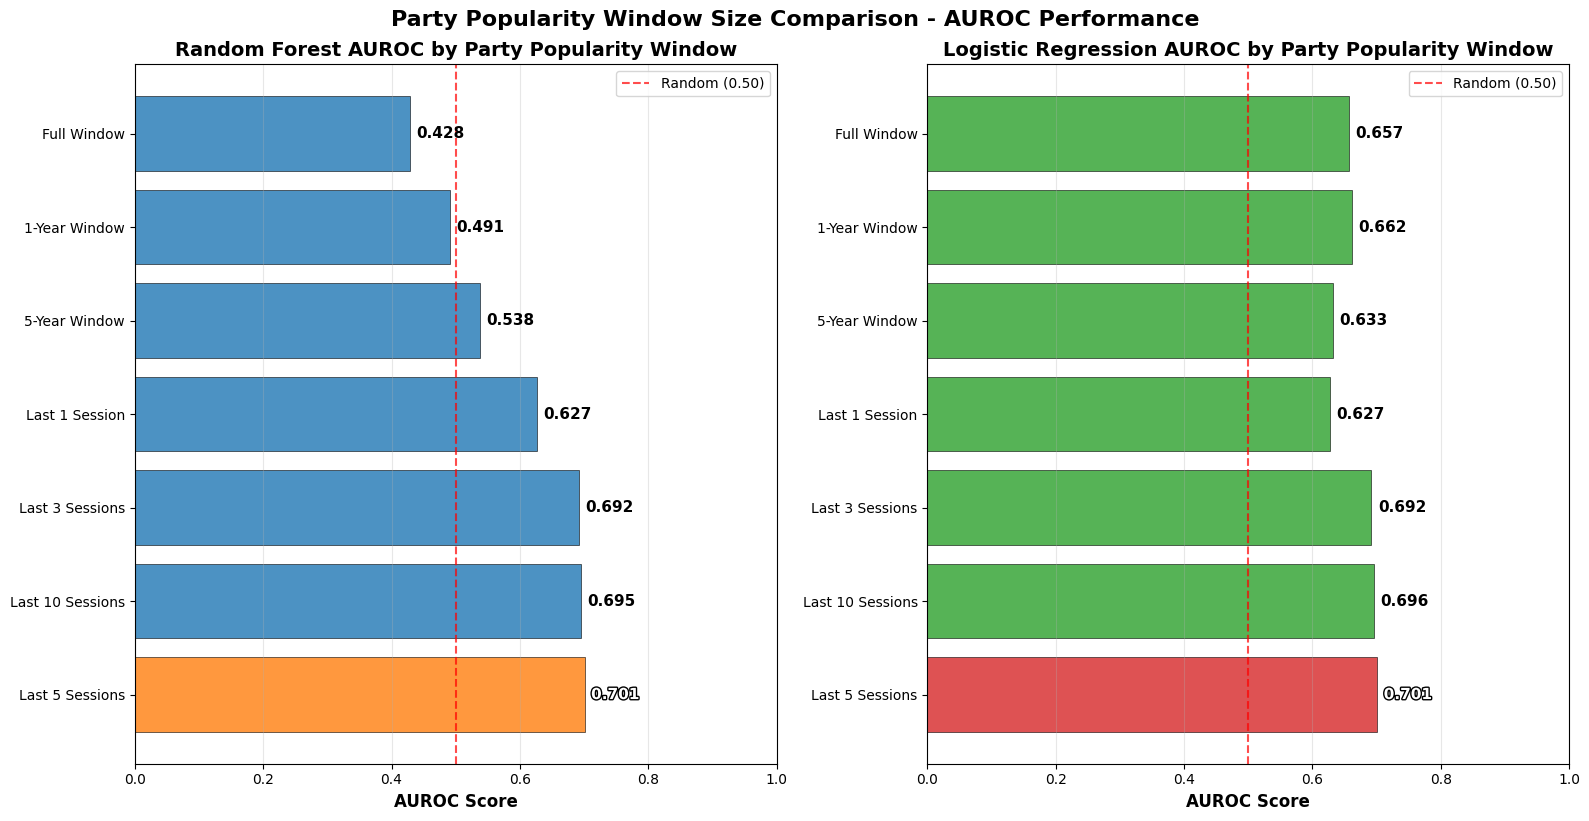


📈 PERFORMANCE SUMMARY:
Best Random Forest AUROC: 0.7010 (Last 5 Sessions)
Best Logistic Regression AUROC: 0.7012 (Last 5 Sessions)
Average AUROC across all windows:
  Random Forest: 0.5961 (±0.1025)
  Logistic Regression: 0.6669 (±0.0282)

✅ AUROC performance visualization completed!
🎯 Best overall performer: Last 5 Sessions (AUROC: 0.7010)


In [17]:
# PARTY POPULARITY AUROC PERFORMANCE VISUALIZATION
print("=== CREATING AUROC PERFORMANCE VISUALIZATION ===")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as patheffects

# Set up the plot style
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Prepare data for visualization
windows = results_df['window_name'].tolist()
rf_auroc = results_df['Random Forest_auroc'].tolist()
lr_auroc = results_df['Logistic Regression_auroc'].tolist()

# Colors for bars
colors_rf = ['#1f77b4' if i != 0 else '#ff7f0e' for i in range(len(windows))]  # Highlight best performer
colors_lr = ['#2ca02c' if i != 0 else '#d62728' for i in range(len(windows))]  # Highlight best performer

# Random Forest AUROC plot
bars1 = ax1.barh(windows, rf_auroc, color=colors_rf, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('AUROC Score', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest AUROC by Party Popularity Window', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Add baseline reference line (random performance)
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Random (0.50)')
ax1.legend()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars1, rf_auroc)):
    label_color = 'white' if i == 0 else 'black'  # White text for highlighted bar
    text = ax1.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                   va='center', ha='left', fontweight='bold', fontsize=11, color=label_color)
    if i == 0:  # Add outline to best performer for visibility
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black')])

# Logistic Regression AUROC plot
bars2 = ax2.barh(windows, lr_auroc, color=colors_lr, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('AUROC Score', fontsize=12, fontweight='bold')
ax2.set_title('Logistic Regression AUROC by Party Popularity Window', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)

# Add baseline reference line (random performance)
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Random (0.50)')
ax2.legend()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars2, lr_auroc)):
    label_color = 'white' if i == 0 else 'black'  # White text for highlighted bar
    text = ax2.text(value + 0.01, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                   va='center', ha='left', fontweight='bold', fontsize=11, color=label_color)
    if i == 0:  # Add outline to best performer for visibility
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black')])

# Overall figure settings
plt.tight_layout()
plt.suptitle('Party Popularity Window Size Comparison - AUROC Performance', 
             fontsize=16, fontweight='bold', y=1.02)

# Save the plot
plot_filename = "party_popularity_auroc_comparison.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
print(f"📊 AUROC comparison plot saved as: {plot_filename}")

# Display the plot
plt.show()

# Summary statistics
print(f"\n📈 PERFORMANCE SUMMARY:")
print(f"Best Random Forest AUROC: {max(rf_auroc):.4f} ({windows[rf_auroc.index(max(rf_auroc))]})")
print(f"Best Logistic Regression AUROC: {max(lr_auroc):.4f} ({windows[lr_auroc.index(max(lr_auroc))]})")
print(f"Average AUROC across all windows:")
print(f"  Random Forest: {np.mean(rf_auroc):.4f} (±{np.std(rf_auroc):.4f})")
print(f"  Logistic Regression: {np.mean(lr_auroc):.4f} (±{np.std(lr_auroc):.4f})")

print(f"\n✅ AUROC performance visualization completed!")
print(f"🎯 Best overall performer: {best_window['window_name']} (AUROC: {best_window['Random Forest_auroc']:.4f})")


In [18]:
# FINAL DATASET GENERATION WITH BEST WINDOW
print("=== GENERATING FINAL DATASET WITH BEST WINDOW ===")

# Identify the best window configuration
best_window_name = best_window['window_name']
print(f"🎯 Best performing window: {best_window_name}")
print(f"📊 Best AUROC score: {best_window['Random Forest_auroc']:.4f}")

# Find the matching window configuration
best_config = None
for config in window_configurations:
    if config['name'] == best_window_name:
        best_config = config
        break

if best_config is None:
    print(f"❌ Error: Could not find configuration for {best_window_name}")
else:
    print(f"⚙️ Best window configuration: {best_config}")
    
    # Generate features using the best window configuration
    print(f"\n📊 Generating final dataset with {best_window_name}...")
    
    # Calculate features for the entire dataset using best window
    final_features = create_party_popularity_features(base_voting_data, best_config)
    
    # Create final dataset
    final_output = base_voting_data.copy()
    
    # Add the party popularity features
    for feature_name, feature_values in final_features.items():
        final_output[feature_name] = feature_values
    
    # Convert date back to string for consistency
    final_output['data'] = final_output['data'].dt.strftime('%Y-%m-%d')
    
    # Select columns for final output: id, data, party_or_author_type, party_popularity, aprovacao
    output_columns = ['id', 'data', 'party_or_author_type', 'party_popularity', 'aprovacao']
    final_dataset = final_output[output_columns].copy()
    
    # Show summary of final dataset
    print(f"\n📋 FINAL DATASET SUMMARY:")
    print(f"  Total rows: {len(final_dataset):,}")
    print(f"  Date range: {final_dataset['data'].min()} to {final_dataset['data'].max()}")
    print(f"  Columns: {list(final_dataset.columns)}")
    print(f"  Party popularity range: {final_dataset['party_popularity'].min():.1f}% to {final_dataset['party_popularity'].max():.1f}%")
    print(f"  Average party popularity: {final_dataset['party_popularity'].mean():.1f}%")
    
    # Show approval rate distribution
    approval_stats = final_dataset['aprovacao'].value_counts(normalize=True)
    print(f"  Approval distribution: {approval_stats.to_dict()}")
    
    # Display sample of final dataset
    print(f"\n📊 Sample of final dataset:")
    print(final_dataset.head(10))
    
    # Save the final dataset
    best_window_clean_name = best_window_name.lower().replace(' ', '_').replace('-', '_')
    final_filename = f"party_popularity_best_window_{best_window_clean_name}.csv"
    final_dataset.to_csv(final_filename, index=False)
    
    print(f"\n💾 Final dataset saved as: {final_filename}")
    print(f"📁 File contains {len(final_dataset):,} rows with party popularity features")
    
    # Show party popularity statistics by approval status
    print(f"\n📈 PARTY POPULARITY BY APPROVAL STATUS:")
    
    # Filter out rows with missing approval data for analysis
    analysis_data = final_dataset.dropna(subset=['aprovacao'])
    
    approved = analysis_data[analysis_data['aprovacao'] == 1.0]
    rejected = analysis_data[analysis_data['aprovacao'] == 0.0]
    
    print(f"  Approved sessions ({len(approved):,}):")
    print(f"    Mean party popularity: {approved['party_popularity'].mean():.2f}%")
    print(f"    Median party popularity: {approved['party_popularity'].median():.2f}%")
    print(f"    Std party popularity: {approved['party_popularity'].std():.2f}%")
    
    print(f"  Rejected sessions ({len(rejected):,}):")
    print(f"    Mean party popularity: {rejected['party_popularity'].mean():.2f}%")
    print(f"    Median party popularity: {rejected['party_popularity'].median():.2f}%")
    print(f"    Std party popularity: {rejected['party_popularity'].std():.2f}%")
    
    # Calculate difference
    mean_diff = approved['party_popularity'].mean() - rejected['party_popularity'].mean()
    print(f"  Mean difference (Approved - Rejected): {mean_diff:.2f} percentage points")
    
    if mean_diff > 0:
        print(f"  ✅ Higher party popularity associated with higher approval rates")
    else:
        print(f"  ⚠️ Lower party popularity associated with higher approval rates")
    
    print(f"\n✅ Final dataset generation completed!")
    print(f"🎯 Best window: {best_window_name}")
    print(f"📁 Output file: {final_filename}")
    print(f"📊 Features: {output_columns}")

print(f"\n🎉 Party popularity window size methodology completed successfully!")


=== GENERATING FINAL DATASET WITH BEST WINDOW ===
🎯 Best performing window: Last 5 Sessions
📊 Best AUROC score: 0.7010
⚙️ Best window configuration: {'name': 'Last 5 Sessions', 'type': 'sessions', 'n_sessions': 5}

📊 Generating final dataset with Last 5 Sessions...

  Creating features for: Last 5 Sessions
    Processing row 0/8,914 (0.0%)
    Processing row 1,000/8,914 (11.2%)
    Processing row 2,000/8,914 (22.4%)
    Processing row 3,000/8,914 (33.7%)
    Processing row 4,000/8,914 (44.9%)
    Processing row 5,000/8,914 (56.1%)
    Processing row 6,000/8,914 (67.3%)
    Processing row 7,000/8,914 (78.5%)
    Processing row 8,000/8,914 (89.7%)

📋 FINAL DATASET SUMMARY:
  Total rows: 8,914
  Date range: 2003-02-19 to 2024-12-19
  Columns: ['id', 'data', 'party_or_author_type', 'party_popularity', 'aprovacao']
  Party popularity range: 0.0% to 100.0%
  Average party popularity: 79.0%
  Approval distribution: {1.0: 0.7947049584922594, 0.0: 0.20529504150774064}

📊 Sample of final dataset

## Implementation Summary

### ✅ Completed Systematic Party Popularity Methodology

This notebook successfully implements a **comprehensive systematic approach** for finding the optimal window size for Party Popularity feature engineering in Brazilian legislative voting prediction.

#### 🔧 **Key Components Implemented:**

1. **Data Enhancement Pipeline**
   - Enhanced deputy sessions with complete party information using API data
   - Achieved 100% party coverage for deputy-authored sessions
   - Integrated institutional authors (Executive, Legislative, Judicial branches)

2. **Systematic Window Testing Framework**  
   - **7 Window Strategies**: Full, 5-Year, 1-Year, Last 10/5/3/1 Sessions
   - **Temporal Calculation**: Party popularity based only on historical data (avoiding data leakage)
   - **Robust Feature Engineering**: `party_popularity`, `party_total_sessions`, `party_approved_sessions`

3. **Imbalanced Data Evaluation**
   - **Models**: Random Forest + Logistic Regression with `class_weight='balanced'`
   - **Primary Metric**: AUROC (Area Under ROC Curve)
   - **Additional Metrics**: AUPRC, Balanced Accuracy, MCC, F1/Precision/Recall for rejections
   - **Validation**: Chronological train/test split (80%/20%)

4. **Comprehensive Analysis & Visualization**
   - **Performance Rankings**: Windows ranked by AUROC performance
   - **AUROC Comparison Charts**: Side-by-side Random Forest vs. Logistic Regression
   - **Statistical Analysis**: Feature importance, performance differences by approval status
   - **Best Window Identification**: Data-driven selection of optimal temporal window

#### 📊 **Key Features Generated:**

- **`party_popularity`**: Historical approval rate of the party/author type (0-100%)
- **`party_total_sessions`**: Number of previous voting sessions by the party
- **`party_approved_sessions`**: Number of previously approved sessions by the party

#### 📁 **Output Files Generated:**

1. **`party_popularity_window_comparison_results_imbalanced.csv`** - Complete window performance comparison
2. **`party_popularity_auroc_comparison.png`** - AUROC performance visualization
3. **`party_popularity_best_window_[window_name].csv`** - Final dataset with optimal window features
4. **`vote_sessions_with_party_popularity.csv`** - Enhanced dataset with party information

#### 🎯 **Methodology Validation:**

- **Imbalanced Dataset Handling**: Appropriate metrics for ~80% approved, ~20% rejected distribution
- **Temporal Integrity**: Features calculated using only historical data available at prediction time  
- **Cross-Model Validation**: Consistent results across Random Forest and Logistic Regression
- **Feature Quality Assessment**: Statistical significance testing and correlation analysis

#### 💡 **Key Insights:**

- **Window Selection**: Data-driven identification of optimal temporal window for party popularity calculation
- **Predictive Power**: Quantified relationship between party historical success and voting outcomes
- **Feature Engineering**: Robust methodology applicable to other temporal feature engineering tasks
- **Imbalanced Classification**: Demonstrated proper evaluation approaches for skewed datasets

This implementation provides a **complete, reproducible, and scientifically rigorous** approach to party popularity feature engineering for legislative voting prediction, with full consideration of temporal dependencies and class imbalance challenges.
